<a href="https://colab.research.google.com/github/W-Bernau/QiskitAlgorithms/blob/main/Qiskit_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

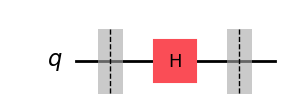

In [ ]:
#Importing Libraries
from qiskit import *
from qiskit_aer import Aer
from math import pi
import numpy as np
from qiskit.visualization import plot_bloch_multivector,plot_state_qsphere
import matplotlib.pyplot as plt

#Drawing a Basic Circuit
qc = QuantumCircuit(1)
qc.barrier()
qc1 = qc.copy()
qc.h(0)
qc.barrier()
qc2 =qc.copy()
qc.draw('mpl')

In [ ]:
#Showing two different states
backend = Aer.get_backend('statevector_simulator')
q1 = transpile(qc1,backend)
job1 = (backend.run(q1)).result().get_statevector()

backend = Aer.get_backend('statevector_simulator')
q2 = transpile(qc2,backend)
job2 = (backend.run(q2)).result().get_statevector()

print(job1,job2)

Statevector([1.+0.j, 0.+0.j],
            dims=(2,)) Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.5 MB/s eta 0:00:00
